>Authors:
>
> - Zofia Agata Lenarczyk s242916
> - Antoine Paul Louis Aubry s243253
> - Dimitrios Tsiliakidis s243204

This notebook contains the assignment 2 for the course Social Graphs and Interactions 2025.

The content of this notebook focuses on the analysis of the rock music network. It explores the rock music network through backbone and community detection, TF-IDF analysis of Wikipedia texts, and sentiment analysis to understand genre and community structure.

In [290]:
# imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import json
from collections import defaultdict, Counter
import pandas as pd
import powerlaw
import matplotlib.patches as mpatches
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import sys
from wordcloud import WordCloud
sys.path.append("https://raw.githubusercontent.com/Azri-oss/Social_Graphs_Assignment_1/main/Assignment_2/libs/backboning.py")
import backboning
#import forceatlas2
from pathlib import Path

In the following parts of the notebook, we will refer to the rock music network created in the Assignment 1 and the *bands folder* containing the Wikipedia texts for all  artists.

In [291]:
url_graph = "https://raw.githubusercontent.com/Azri-oss/Social_Graphs_Assignment_1/main/Assignment_1/Rock_Music_Network.graphml"

r = requests.get(url_graph)
with open("Rock_Music_Network.graphml", "wb") as f:
    f.write(r.content)

graph = nx.read_graphml("Rock_Music_Network.graphml")

# Part 1: Analyze the network

## Step 1: Load and inspect the Rock Music network

In this section, we begin by loading the directed network of rock artists and bands built from Wikipedia hyperlinks.  
Each node represents a musician or band, and each directed edge represents a hyperlink from one artist’s page to another.  
The goal is to characterize the network structure by examining connectivity patterns, starting with degree distributions.

In [293]:
# Load graph
G = nx.read_graphml("Rock_Music_Network.graphml")

# Basic summary
print(f"Directed: {G.is_directed()}")
print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")

# (Optional) list node attributes available
sample_node = next(iter(G.nodes()))
print("Example node attributes:", G.nodes[sample_node])

Directed: True
Number of nodes: 484
Number of edges: 7,326
Example node attributes: {}


## Step 2: Relationship between In-degree and Out-degree

In this scatter plot below, we explore the relationship between **in-degree** and **out-degree** for each artist.  
This helps us understand whether highly referenced artists (many incoming links) are also those who reference many others (many outgoing links). 

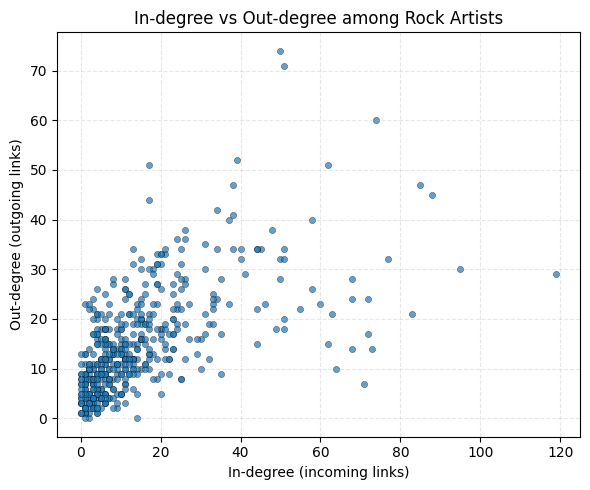

In [294]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]
plt.figure(figsize=(6,5))
plt.scatter(in_degrees, out_degrees, s=20, alpha=0.7, edgecolors='k', linewidth=0.3)
plt.xlabel("In-degree (incoming links)")
plt.ylabel("Out-degree (outgoing links)")
plt.title("In-degree vs Out-degree among Rock Artists")
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

The scatter plot shows the relationship between the number of incoming and outgoing links for each artist.  
Most nodes are concentrated near the origin, meaning that the majority of artists have few connections in either direction.  
A smaller number of artists stand out with high in-degree and/or out-degree, confirming that the network is highly heterogeneous.

### Step 2.1: Power-law characteristics of the degree distributions

The scatter plot above illustrated that most artists have relatively few incoming and outgoing links, while a few stand out with much higher values.  
This pattern is typical of **heavy-tailed** or **power-law** distributions, which are common in real-world information networks like Wikipedia.  

To examine whether the Rock Music network follows such a pattern, we estimate the **power-law exponent (α)** for the in-degree and out-degree distributions.  
The exponent characterizes how quickly the probability of observing high-degree nodes decays - smaller values indicate a slower decay and therefore more hubs.

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-degree α (exponent): 2.55 | xmin: 15.0
Out-degree α (exponent): 3.86 | xmin: 20.0


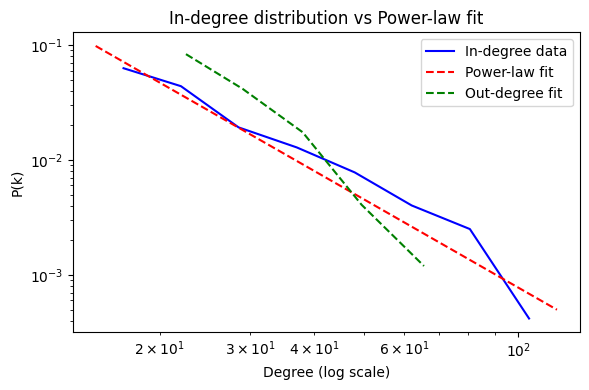

In [295]:
# Fit power-law distributions for in-degree and out-degree
fit_in = powerlaw.Fit(in_degrees, discrete=True)
fit_out = powerlaw.Fit(out_degrees, discrete=True)

print(f"In-degree α (exponent): {fit_in.alpha:.2f} | xmin: {fit_in.xmin}")
print(f"Out-degree α (exponent): {fit_out.alpha:.2f} | xmin: {fit_out.xmin}")

# Visualization (compare data with fitted power-law)
fig, ax = plt.subplots(figsize=(6,4))
fit_in.plot_pdf(color='blue', label='In-degree data')
fit_in.power_law.plot_pdf(color='red', linestyle='--', ax=ax, label='Power-law fit')
ax.set_xlabel("Degree (log scale)")
ax.set_ylabel("P(k)")
ax.set_title("In-degree distribution vs Power-law fit")
plt.legend()
plt.tight_layout()
fit_out.plot_pdf(color='green', linestyle='--', ax=ax, label='Out-degree fit')
plt.legend()
plt.show()

At first glance, one might expect many pages to link broadly to others, producing a heavy-tailed out-degree distribution. However, the fitted exponents reveal the opposite: the **out-degree tail decays much faster (α ≈ 3.9)** than the **in-degree tail (α ≈ 2.6)**.  
This indicates that only a handful of Wikipedia pages - typically *“list”* or *“overview”* articles - contain a large number of outgoing links, while most musician pages link to only a few related artists.  

In contrast, the **in-degree distribution** is more uneven: many pages reference the same few iconic artists (*The Beatles*, *Queen*, *Led Zeppelin*), leading to a heavier tail and lower exponent.  
This asymmetry between in- and out-degree is typical of **citation- or hyperlink-type networks**, where attention (incoming links) concentrates among a few highly visible nodes, while outgoing connections remain relatively constrained.  

> **Reference:**  
> Clauset, A., Shalizi, C. R., & Newman, M. E. J. (2009). *Power-law distributions in empirical data.* **SIAM Review**, 51(4), 661–703. [https://doi.org/10.1137/070710111](https://doi.org/10.1137/070710111)

## Step 3: Centrality and influence

We quantify importance with three complementary measures on the **directed** network:
- **In-degree centrality** (popularity): many pages link *to* the artist.
- **Out-degree centrality** (referential activity): the artist page links *to* many others.
- **Betweenness centrality** (brokerage): the artist sits on many shortest paths.

In [296]:
in_deg_c = nx.in_degree_centrality(G)
out_deg_c = nx.out_degree_centrality(G)
bet_c = nx.betweenness_centrality(G, normalized=True)

cent_df = pd.DataFrame({
    "in_degree_c": pd.Series(in_deg_c),
    "out_degree_c": pd.Series(out_deg_c),
    "betweenness": pd.Series(bet_c),
})
cent_df["in_degree"] = [G.in_degree(n) for n in cent_df.index]
cent_df["out_degree"] = [G.out_degree(n) for n in cent_df.index]

def topk(df, col, k=5):
    return df.sort_values(col, ascending=False).head(k)

print("Top-5 by IN-degree centrality")
display(topk(cent_df, "in_degree_c"))

print("Top-5 by OUT-degree centrality")
display(topk(cent_df, "out_degree_c"))

print("Top-5 by Betweenness centrality")
display(topk(cent_df, "betweenness"))

Top-5 by IN-degree centrality


in_degree_c  out_degree_c  betweenness  in_degree  out_degree
Led_Zeppelin     0.246377      0.060041     0.034338        119          29
Bob_Dylan        0.196687      0.062112     0.029399         95          30
Queen_(band)     0.182195      0.093168     0.039386         88          45
Metallica        0.175983      0.097308     0.025134         85          47
David_Bowie      0.171843      0.043478     0.013373         83          21

Top-5 by OUT-degree centrality


in_degree_c  out_degree_c  betweenness  in_degree  out_degree
Alice_in_Chains     0.103520      0.153209     0.036628         50          74
Deep_Purple         0.105590      0.146998     0.042996         51          71
Black_Sabbath       0.153209      0.124224     0.031943         74          60
Def_Leppard         0.080745      0.107660     0.022372         39          52
Guns_N'_Roses       0.128364      0.105590     0.035204         62          51

Top-5 by Betweenness centrality


in_degree_c  out_degree_c  betweenness  in_degree  out_degree
Deep_Purple         0.105590      0.146998     0.042996         51          71
Queen_(band)        0.182195      0.093168     0.039386         88          45
Alice_in_Chains     0.103520      0.153209     0.036628         50          74
Guns_N'_Roses       0.128364      0.105590     0.035204         62          51
Led_Zeppelin        0.246377      0.060041     0.034338        119          29

Centrality measures highlight different forms of importance within the rock musician network.  

**In-degree centrality** reflects *popularity* - how many other artists reference a band.  
High in-degree artists such as **Led Zeppelin**, **Bob Dylan**, and **Queen** are widely recognized and influential, serving as key reference points within the rock genre.  

**Out-degree centrality** captures *referential activity* - how many other pages an artist links to.  
Bands like **Alice in Chains**, **Deep Purple**, and **Black Sabbath** frequently cite peers and influences, indicating detailed and well-connected Wikipedia pages.  

**Betweenness centrality** identifies *bridges* in the network.  
Artists such as **Deep Purple**, **Queen**, and **Guns N’ Roses** connect different musical clusters (e.g., classic rock, metal), showing their role in linking subgenres.

### Step 3.1: Betweenness Centrality vs. Degree Centrality

Next, we explore how **betweenness centrality** relates to **degree centrality**. While degree measures how many direct connections a node has,  
betweenness captures how often a node lies on the *shortest paths* between other nodes - acting as a “bridge” that connects otherwise distant parts of the network.  

By comparing the two, we can assess whether the most connected artists are also the most structurally important intermediaries in the network.

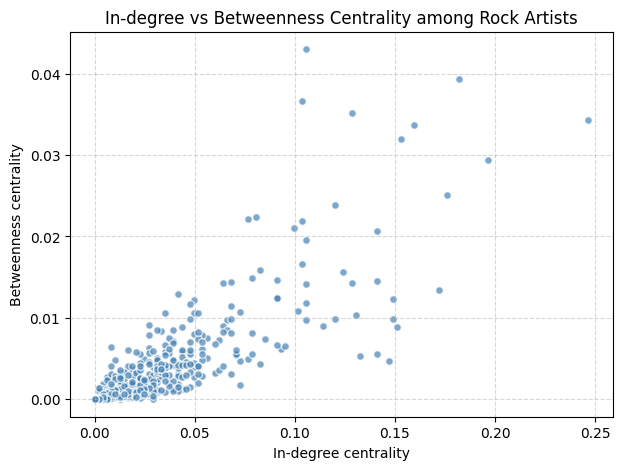

Correlation between in-degree and betweenness centrality: 0.816


In [297]:
# Clean scatter plot: Degree vs Betweenness centrality
plt.figure(figsize=(7, 5))
plt.scatter(
    cent_df["in_degree_c"], cent_df["betweenness"],
    s=30, color='steelblue', edgecolor='white', alpha=0.7
)
plt.title("In-degree vs Betweenness Centrality among Rock Artists")
plt.xlabel("In-degree centrality")
plt.ylabel("Betweenness centrality")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Compute correlation
corr = cent_df["in_degree_c"].corr(cent_df["betweenness"])
print(f"Correlation between in-degree and betweenness centrality: {corr:.3f}")

In the scatter plot above, we observe a **dense cluster of nodes** concentrated near the bottom-left corner.  
This region represents the majority of artists who have **low in-degree** (few incoming links) and **low betweenness centrality** (limited bridging influence).  
These are typically smaller or niche bands that are only connected within specific subgenres.

A clear **positive correlation (r = 0.816)** emerges between in-degree and betweenness centrality,  
indicating that artists who are more frequently referenced also tend to occupy key positions as **bridges** between different parts of the network.  
For instance, highly cited figures such as *Led Zeppelin* or *Bob Dylan* not only attract numerous links but also connect otherwise distinct musical communities.

### Step 3.2: Degree Assortativity

The **degree assortativity coefficient** describes how nodes with similar degrees tend to connect in a network.

- A **positive value** indicates *assortative mixing*, meaning that highly connected artists are more likely to link with other highly-connected ones.  
- A **negative value** reflects *disassortative mixing*, where highly connected hubs tend to connect with lesser-connected or peripheral artists.  
- A value **close to zero** suggests *neutral mixing*, where connections are formed randomly with little or no preference for degree similarity.

In [298]:
# Degree assortativity coefficient 
G_undirected = G.to_undirected()

assortativity = nx.degree_assortativity_coefficient(G_undirected)
print(f"Degree assortativity coefficient: {assortativity:.3f}")

Degree assortativity coefficient: 0.008


The calculated **degree assortativity coefficient** is **0.008**, indicating almost no correlation between the degrees of connected artists. This means that highly connected artists (e.g., *Led Zeppelin*, *Queen*) link to both prominent and lesser-known pages with similar frequency.  

The network thus shows **neutral mixing**, where link formation is driven more by relevance or historical association than by popularity. Such near-zero assortativity is typical for **informational networks** like Wikipedia, unlike social networks, which often show strong positive assortativity.

### Step 3.3: Assortativity by Article Length
Goal: test whether the **undirected** Rock Music network is assortative with respect to a node attribute, **`length_of_content`** (Wikipedia article length).  
Reference: Newman (2003), *Mixing patterns in networks*.

In the first step, JSON files containing the Wikipedia text of each artist or band are processed.  
The script extracts the textual content (favoring the `wikitext` key), measures its character length, and normalizes the page titles to ensure consistent matching between filenames and network node labels.  

The resulting `length_of_content` attribute is then attached to each node in the graph, providing a quantitative measure of how extensive each artist’s Wikipedia page is.

In [299]:
JSON_DIR = Path("bands")  
def norm(s):
    s = (s or "").replace("_"," ").strip().lower()
    s = re.sub(r"\s*\(.*?\)\s*$","", s)          # drop "(band)" etc.
    return re.sub(r"\s+"," ", s)

def grab_text(rec):
    if isinstance(rec, str): return rec
    if isinstance(rec, dict):
        for k in ("wikitext","content","text","extract","summary","body","plain_text","wiki_text"):
            v = rec.get(k)
            if isinstance(v, str) and v.strip(): return v
        return " ".join(filter(None, (grab_text(v) for v in rec.values())))
    if isinstance(rec, list):
        return " ".join(filter(None, (grab_text(x) for x in rec)))
    return ""

# 1) Read lengths
title_len = {}
for p in sorted(JSON_DIR.glob("*.json")):
    try:
        rec = json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        continue
    title = rec.get("page") if isinstance(rec, dict) else p.stem
    title_len[norm(title)] = len(grab_text(rec))
print(f"Loaded {len(title_len)} normalized titles")

# 2) Map to nodes & set attribute
idx = {}
for n in G.nodes(): 
    idx.setdefault(norm(str(n)), []).append(n)

attr, matches = {}, 0
for t, L in title_len.items():
    if t in idx:
        for n in idx[t]:
            attr[n] = L
        matches += 1

nx.set_node_attributes(G, attr, "length_of_content")
cov = sum("length_of_content" in G.nodes[n] for n in G.nodes())
print(f"Attached length to {cov}/{G.number_of_nodes()} nodes ({cov/G.number_of_nodes():.1%}) | matched titles: {matches}")

Loaded 485 normalized titles
Attached length to 484/484 nodes (100.0%) | matched titles: 481


In this section, the network is transformed into its **undirected giant connected component (GCC)** to ensure that all nodes are mutually reachable.  
The analysis then filters for nodes with valid numerical values for `length_of_content`, computes the **numeric assortativity coefficient**, and examines whether nodes with long pages are more likely to connect to similarly lengthy ones.  

Additionally, Pearson and Spearman correlations between node degree and article length are calculated to assess whether high-degree nodes tend to have more detailed Wikipedia pages.

In [300]:
# 3) Assortativity on undirected GCC (numeric)
Gu = G.to_undirected()
Gu = Gu.subgraph(max(nx.connected_components(Gu), key=len)).copy()

keep = [n for n,d in Gu.nodes(data=True) 
        if isinstance(d.get("length_of_content"), (int,float)) and np.isfinite(d["length_of_content"])]
H = Gu.subgraph(keep).copy()

vals = np.array([H.nodes[n]["length_of_content"] for n in H.nodes()])
if H.number_of_edges() and H.number_of_nodes() >= 3 and np.std(vals) > 0:
    r = nx.numeric_assortativity_coefficient(H, "length_of_content")
    print(f"[chars] assortativity: {r:.3f} | nodes used: {H.number_of_nodes()} | edges used: {H.number_of_edges()} | ok")
else:
    print("Assortativity by length: undefined (insufficient data)")

# 4) Degree–length (context)
deg = dict(H.degree())
df = pd.DataFrame({"deg":[deg[n] for n in H],
                   "len":[H.nodes[n]["length_of_content"] for n in H]})
print("Pearson(deg,len)  =", df["deg"].corr(df["len"]))
print("Spearman(deg,len) =", df["deg"].corr(df["len"], method="spearman"))

[chars] assortativity: 0.048 | nodes used: 484 | edges used: 6023 | ok
Pearson(deg,len)  = 0.7124797023313804
Spearman(deg,len) = 0.7210222941024341


The **undirected Rock Music network** shows a **slightly positive numeric assortativity** with respect to `length_of_content` (r ≈ 0.04–0.05), indicating a **weak tendency** for artists with long Wikipedia pages to connect to others with similarly detailed articles.  

This occurs because **well-known artists** (e.g., *The Beatles*, *Queen*, *The Rolling Stones*) often link to each other, but also to **less-known bands** with shorter pages - reducing overall assortativity.

By contrast, the **strong correlation** between node degree and article length (Pearson ≈ 0.71, Spearman ≈ 0.72) suggests that **highly connected artists** tend to have longer pages, reflecting editorial focus on **popular and influential bands**.

In summary, the network is **not strongly assortative** by article length, with connections shaped more by **thematic or historical relevance** than by page size.

## Step 4: Backbones and Network Visualization

In this step, we visualize the backbone of the undirected Rock Music Network obtained using the **Disparity Filter** (α = 0.75).  
Edge weights represent the **Edge Betweenness Centrality (EBC)** rescaled to [1, 100], highlighting connections that act as important bridges.  

In [301]:
G_u = nx.Graph(G)  # Make an undirected copy explicitly

gcc_nodes = max(nx.connected_components(G_u), key=len)
G_gcc = G_u.subgraph(gcc_nodes).copy()

if G.is_directed():
    total_degree = {n: G.in_degree(n) + G.out_degree(n) for n in G_gcc.nodes()}
else:
    total_degree = dict(G_gcc.degree())

nx.set_node_attributes(G_gcc, total_degree, "total_degree")

print(f"GCC: {G_gcc.number_of_nodes()} nodes, {G_gcc.number_of_edges()} edges")
print("Total-degree stats:",
      f"min={min(total_degree.values())},",
      f"max={max(total_degree.values())},",
      f"mean={np.mean(list(total_degree.values())):.2f}")

GCC: 484 nodes, 6023 edges
Total-degree stats: min=1, max=148, mean=30.27


In [302]:
ebc = nx.edge_betweenness_centrality(G_gcc, normalized=True) # Compute EBC on the undirected GCC

values = np.fromiter(ebc.values(), dtype=float)
vmin, vmax = float(values.min()), float(values.max())

def rescale(v, vmin, vmax, low=1.0, high=100.0):
    if vmax == vmin:
        return float(low)
    return float(low + (high - low) * ((v - vmin) / (vmax - vmin)))

ebc_rescaled = {e: rescale(w, vmin, vmax, 1.0, 100.0) for e, w in ebc.items()}

# Build the edge table for the backboning module (src, trg, nij)
edges_w = [{"source": u, "target": v, "weight": w} for (u, v), w in ebc_rescaled.items()]
df_wn1_pretty = pd.DataFrame(edges_w)
df_wn1_for_backbone = df_wn1_pretty.rename(columns={"source": "src", "target": "trg", "weight": "nij"})
print(f"Weighted Network 1 edge table: {df_wn1_pretty.shape}")

scored_wn1 = backboning.disparity_filter(df_wn1_for_backbone, undirected=True)
print(f"Disparity filter applied — resulting dataframe shape: {scored_wn1.shape}")

Weighted Network 1 edge table: (6023, 3)
Disparity filter applied — resulting dataframe shape: (6021, 5)


Calculating DF score...


In [303]:
# Explore how different alpha thresholds affect the backbone density
gen = backboning.test_densities(scored_wn1, start=0.50, end=0.80, step=0.02)
dens_wn1_df = pd.DataFrame(gen)

if dens_wn1_df.shape[1] == 7:
    dens_wn1_df.columns = ['alpha','nodes','pct_nodes','edges','pct_edges','avg_degree','density']

if 'edges' in dens_wn1_df.columns:
    changes = dens_wn1_df.loc[dens_wn1_df['edges'].diff().fillna(0) != 0]
else:
    changes = dens_wn1_df.loc[dens_wn1_df.iloc[:,3].diff().fillna(0) != 0]

print("Alpha sweep summary")
print(changes)

Alpha sweep summary
    alpha  nodes   pct_nodes  edges  pct_edges  avg_degree   density
1    0.52    484  100.000000   3906  64.872945   16.140496  0.648729
2    0.54    484  100.000000   3524  58.528484   14.561983  0.585285
3    0.56    484  100.000000   3175  52.732104   13.119835  0.527321
4    0.58    483   99.793388   2829  46.985551   11.714286  0.470828
5    0.60    482   99.586777   2491  41.371865   10.336100  0.415435
6    0.62    479   98.966942   2225  36.953994    9.290188  0.373397
7    0.64    478   98.760331   1966  32.652383    8.225941  0.330622
8    0.66    475   98.140496   1704  28.300947    7.174737  0.288372
9    0.68    470   97.107438   1488  24.713503    6.331915  0.254496
10   0.70    464   95.867769   1257  20.876931    5.418103  0.217768
11   0.72    457   94.421488   1074  17.837569    4.700219  0.188914
12   0.74    439   90.702479    908  15.080551    4.136674  0.166264
13   0.76    424   87.603306    751  12.473011    3.542453  0.142381
14   0.78    4

In [304]:
alpha = 0.75  # balanced sparsity

backbone_edges = backboning.thresholding(scored_wn1, threshold=alpha)
backbone_edges_pretty = backbone_edges.rename(
    columns={"src":"source","trg":"target","nij":"weight"}
)

print("Backbone shape:", backbone_edges_pretty.shape) 

G_backbone = nx.Graph()
G_backbone.add_nodes_from(G_gcc.nodes(data=True))
G_backbone.add_weighted_edges_from(
    backbone_edges_pretty[['source','target','weight']].itertuples(index=False, name=None)
)

# Largest Connected Component (removes 1–2 isolates)
lcc_nodes = max(nx.connected_components(G_backbone), key=len)
G_backbone_lcc = G_backbone.subgraph(lcc_nodes).copy()
print(f"LCC: {G_backbone_lcc.number_of_nodes()} nodes, {G_backbone_lcc.number_of_edges()} edges")

Backbone shape: (821, 4)
LCC: 429 nodes, 819 edges


In [305]:
pct_nodes = 100 * G_backbone_lcc.number_of_nodes() / G_gcc.number_of_nodes()
pct_edges = 100 * G_backbone_lcc.number_of_edges() / G_gcc.number_of_edges()
print(f"Retention @ α={alpha}: nodes={pct_nodes:.1f}% of GCC, edges={pct_edges:.1f}% of GCC")

Retention @ α=0.75: nodes=88.6% of GCC, edges=13.6% of GCC


We tested different α values (from 0.50 to 0.80) to explore how the disparity filter affects the structure of the Rock Music Network.  
Lower α values produced overly dense networks that were difficult to interpret, while higher values removed too many connections and reduced connectivity.

After comparing several results, we selected **α = 0.75** because it provides a clear and balanced representation of the network.  
At this threshold:

- The network keeps **most of the key artists** (≈ 88.6% of the original nodes).  
- It retains only **the strongest and most meaningful relationships** (≈ 13.6% of edges).  
- The overall structure remains connected and visually interpretable.

This α value therefore represents a good compromise between **clarity** and **information preservation**, allowing the main connections in the network to stand out without losing important structural relationships.

In [ ]:
if not hasattr(nx, "to_numpy_matrix"):
    def _to_numpy_matrix(G, weight=None, dtype=None, nodelist=None, order=None):
        return nx.to_numpy_array(G, weight=weight, dtype=dtype, nodelist=nodelist, order=order)
    nx.to_numpy_matrix = _to_numpy_matrix

pos_fa2 = forceatlas2.forceatlas2_networkx_layout(
    G_backbone_lcc,
    pos=None,
    niter=2000
)
print("Computed FA2 positions for", len(pos_fa2), "LCC nodes")

In [ ]:
deg = np.array([G_backbone_lcc.nodes[n].get("total_degree", 1) for n in G_backbone_lcc.nodes()])
node_sizes = 12 + 1.6 * np.sqrt(deg)  

plt.figure(figsize=(10,10))

nx.draw_networkx_edges(
    G_backbone_lcc, pos_fa2,
    width=0.55,      
    alpha=0.25      
)

nx.draw_networkx_nodes(
    G_backbone_lcc, pos_fa2,
    node_size=node_sizes,
    linewidths=0,
    edgecolors=None
)

top_k = 8
top_nodes = [n for n, d in sorted(G_backbone_lcc.nodes(data=True),
                                  key=lambda x: x[1].get("total_degree", 0),
                                  reverse=True)[:top_k]]
nx.draw_networkx_labels(G_backbone_lcc, pos_fa2, labels={n: n for n in top_nodes}, font_size=7)

plt.axis("off")
plt.title("WN1 Backbone (Disparity Filter, α = 0.75)", pad=12)
plt.show()

# Part 2: Genres and communities and plotting 


>* Write about genres and modularity.
>* Detect the communities, discuss the value of modularity in comparison to the genres.
>* Calculate the matrix $D$ and discuss your findings.
>* Plot the communities and comment on your results.


### **Question 2.1 :** Write about genres and modularity

In this question, we first aim to gather the genres of each artist into a single dictionary called *dict_mapping*. This will allow us to analyze the network through the lens of rock artists genres.

In [319]:
# Because some of the wikipedia pages have different names for a same genre, we need to do a normalization.

GENRE_NORMALIZATION = {
    "rock'n'roll": "rock and roll",
    "rock & roll": "rock and roll",
    "rock&roll": "rock and roll",
    "hip-hop": "hip hop",
    "r&b": "rhythm and blues",
    "rhythm & blues": "rhythm and blues",
    "rnb": "rhythm and blues",
    "r b": "rhythm and blues",
}
def normalize_genre_mapping(genre):
    g = genre.lower().strip()
    g = g.replace("'", "").replace('"', "")
    g = re.sub(r'\s+', ' ', g)
    return GENRE_NORMALIZATION.get(g, g)



In [320]:
# Regex was done using LLM
def extract_genres_from_wikitext_simple(wikitext):
    """
    Only extract genres from [[...]] just after | genre = ...
    Stop capturing as soon as another field starts (|).
    """
    if not wikitext:
        return []

    genres_found = []

    # delete HTML comments
    text = re.sub(r'<!--.*?-->', '', wikitext, flags=re.DOTALL)
    # only get information after genre= and before "|"
    match = re.search(r'\|\s*genre\s*=\s*((?:.|\n)*?)(?=\n\s*\||<ref>|$|\Z)', text, re.IGNORECASE)
    # if no genre field found
    if not match:
        return []
    # get the block of text after genre=
    block = match.group(1)

    # extract content inside [[...]]
    links = re.findall(r'\[\[([^\]]+)\]\]', block) 
    for link in links:
        # part after "|" if it exists
        genre = link.split('|')[-1].strip().lower()
        # remove parentheses and content inside
        genre = re.sub(r'\(.*?\)', '', genre) 
        # to keep special characters like ä, letters and figures.
        genre = re.sub(r'[^(\w)\s&/-]', ' ', genre) 
        # normalize spaces
        genre = re.sub(r'\s+', ' ', genre).strip() 
        if genre:
            genres_found.append(genre)

    return genres_found



In [321]:
import requests, zipfile, io, os


def genre_mapping(JSON_DIR=JSON_DIR):
    dict = {}
    for fname in os.listdir(JSON_DIR):
        path = os.path.join(JSON_DIR, fname)
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        # get artist name and wikitext from JSON file
        artist = data.get('page','')
        wikitext = data.get('wikitext','')
        genres = extract_genres_from_wikitext_simple(wikitext)
        normalized_genres = [normalize_genre_mapping(g) for g in genres]
        dict[artist] = normalized_genres
    return dict

dict_mapping = genre_mapping()

In [322]:
def stats_genres(dict_mapping):
    count_nodes_with_genres = 0
    sum_genres = 0
    all_genres = []
    hist_genres = {}
    for genres in dict_mapping.values():
        if genres:  # only consider artists with at least one genre
            count_nodes_with_genres += 1
            # keep track of the total number of genres for all artists
            sum_genres += len(genres)
            all_genres.extend([g for g in genres])
            for g in genres:
                hist_genres[g] = hist_genres.get(g, 0) + 1
    # keep distinct genres from all_genres
    distinct_genres = set(all_genres)

    return count_nodes_with_genres, sum_genres/len(dict_mapping), len(distinct_genres), hist_genres


nodes_with_genres, average_genres, distinct_genres_count, genre_distribution = stats_genres(dict_mapping)
print("Statistics on genres:")
print("Number of nodes with genres:", nodes_with_genres)
print("Average number of genres per node:", average_genres)
print("Total distinct genres:", distinct_genres_count)

Statistics on genres:
Number of nodes with genres: 478
Average number of genres per node: 3.5348360655737703
Total distinct genres: 215


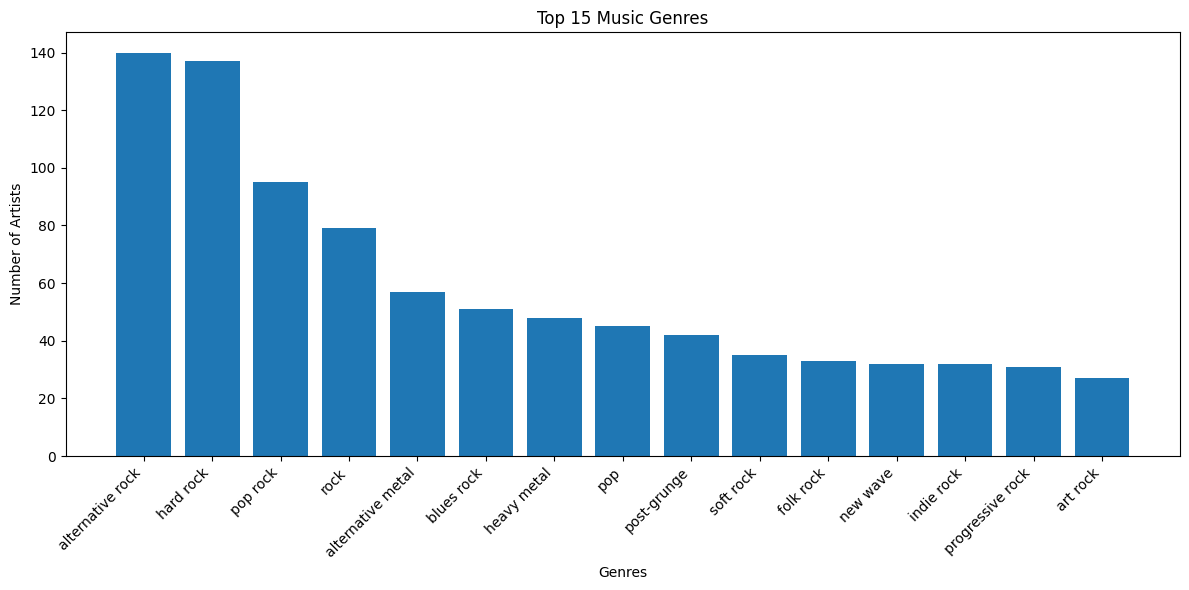

In [323]:
top_genres = sorted(list(genre_distribution.items()), key=lambda x: x[1], reverse=True)[:15]
plt.figure(figsize=(12,6))
plt.bar([x[0] for x in top_genres], [x[1] for x in top_genres])
plt.xlabel("Genres")
plt.ylabel("Number of Artists")
plt.title("Top 15 Music Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Observation* : On average, each artist is associated with several genres. Moreover we were surprised by the large number of distinct genres. These two observations reveal that Rock Music is highly diverse, even among its most well known artists.
The histogram also shows that *alternative rock* and *hard rock* are the two predominant genres and that many subgenres of rock exist and play a significant role in the rock music sphere.

**Modularity :** The modularity represents the ability of a graph to have distinct and strong communities. Indeed, by taking into account inter-community and extra community edges, this measure indicates if the graph can be divided into communities and clusters. The following formula gives the modularity of a graph :

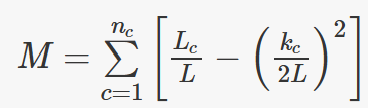

With 
* n<sub>c</sub>: number of communities
* L<sub>c</sub>: number of edges within the community C
* k<sub>c</sub>: total degree of the nodes in the community C
* L: number of edges in the graph

Thus having a better modularity (higher) means that the partition offer a better community structure. Indeed, having **M<=0** reflects a poor partition whereas having **M closer to 1** indicates a stronger community division.

### **Question 2.2 :** Detect the communities, discuss the value of modularity in comparison to the genres.

In [324]:
G_undirected = graph.to_undirected()

def remove_nodes_without_genres(G_undirected, dict_mapping):
    # Identify nodes without genres
    nodes_to_remove = [node for node in G_undirected.nodes() if dict_mapping.get(node)== []]
    print("Nodes to remove:", nodes_to_remove)
    # Remove nodes without genres from graph
    G_undirected.remove_nodes_from(nodes_to_remove)
    return G_undirected
    
remove_nodes_without_genres(G_undirected, dict_mapping)
        

Nodes to remove: ['Electric_Light_Orchestra', 'Poison_(American_band)', 'Dallas_Green_(musician)', 'The_Zombies', 'Pat_Benatar', 'The_Boxtones']


### Create communities based on the genre

For the following part we have decided to use the first listed genre to represent the genre of an artist. Indeed we assume that the genre appearing first on the Wikipedia page is usually the most representative of the artist work.

In [325]:
def label_nodes_by_genre(G_undirected, dict_mapping):
    distinct_genres = []
    for node in G_undirected.nodes():
        # Assign the first genre for the artist
        first_genre = dict_mapping.get(node)[0]
        G_undirected.nodes[node]['genre'] = first_genre
        distinct_genres.append(first_genre)
    distinct_genres = set(distinct_genres)
    return G_undirected, distinct_genres

G_undirected, distinct_genres = label_nodes_by_genre(G_undirected, dict_mapping)
print(G_undirected.nodes(data=True))
print("Distinct genres assigned:", len(distinct_genres))

[('38_Special_(band)', {'genre': 'hard rock'}), ('Jefferson_Starship', {'genre': 'rock'}), ('Peter_Frampton', {'genre': 'rock'}), ('REO_Speedwagon', {'genre': 'arena rock'}), ('Billy_Joel', {'genre': 'rock'}), ('Ted_Nugent', {'genre': 'hard rock'}), ('Lynyrd_Skynyrd', {'genre': 'southern rock'}), ('Bryan_Adams', {'genre': 'rock'}), ('Survivor_(band)', {'genre': 'rock'}), ('Huey_Lewis_and_the_News', {'genre': 'rock'}), ('Bon_Jovi', {'genre': 'hard rock'}), ('Journey_(band)', {'genre': 'arena rock'}), ('Kiss_(band)', {'genre': 'hard rock'}), ('Styx_(band)', {'genre': 'progressive rock'}), ('10cc', {'genre': 'art rock'}), ("Herman's_Hermits", {'genre': 'beat'}), ('Ringo_Starr', {'genre': 'rock'}), ('Queen_(band)', {'genre': 'rock'}), ('George_Harrison', {'genre': 'rock'}), ('Jethro_Tull_(band)', {'genre': 'progressive rock'}), ('Peter_Gabriel', {'genre': 'progressive rock'}), ('The_Police', {'genre': 'new wave'}), ('Toto_(band)', {'genre': 'arena rock'}), ('Asia_(band)', {'genre': 'progre

We lost some information because we went from 215 distinct genres to 80 but we kept the most meaninful.

In [326]:
def create_communities_by_genre(G_undirected):
    # Order nodes by genre
    sorted_nodes_by_genre = sorted(G_undirected.nodes(data=True), key=lambda x: x[1]['genre'])
    list_communities = []
    # Initialize first community
    community = [sorted_nodes_by_genre[0][0]]
    for i in range(1,len(sorted_nodes_by_genre)):
        # Test if genre changed
        if sorted_nodes_by_genre[i][1]['genre'] != sorted_nodes_by_genre[i-1][1]['genre']:
            # New community
            list_communities.append(community)
            community = [sorted_nodes_by_genre[i][0]]
        else:
            community.append(sorted_nodes_by_genre[i][0])
    list_communities.append(community)  # append last community
    return list_communities


list_communities = create_communities_by_genre(G_undirected)
print(list_communities)

[['10_Years_(band)', 'Deftones', 'Mudvayne', 'Faith_No_More', 'Staind', 'Stone_Sour', 'Godsmack', 'Chris_Cornell', 'Tool_(band)', 'Evanescence', 'System_of_a_Down', 'Primus_(band)', 'Drowning_Pool'], ['Barenaked_Ladies'], ['Stone_Temple_Pilots', 'Linkin_Park', '311_(band)', "Jane's_Addiction", 'Incubus_(band)', 'Papa_Roach', 'Morrissey', 'Pearl_Jam', 'My_Chemical_Romance', 'Alanis_Morissette', 'Foo_Fighters', 'Matchbox_Twenty', 'Garbage_(band)', 'Midnight_Oil', 'Pixies_(band)', 'Hoobastank', 'Queens_of_the_Stone_Age', 'Fuel_(band)', 'Gin_Blossoms', 'Beck', 'Cage_the_Elephant', 'Goo_Goo_Dolls', 'Third_Eye_Blind', 'Hole_(band)', 'Coldplay', 'Our_Lady_Peace', 'Awolnation', 'Twenty_One_Pilots', 'A_Perfect_Circle', 'Weezer', 'The_Smashing_Pumpkins', 'Live_(band)', 'R.E.M.', 'Ben_Folds_Five', 'The_Tragically_Hip', 'Muse_(band)', 'Highly_Suspect', 'Jimmy_Eat_World', 'Bloodhound_Gang', 'Blue_October', 'Starset', 'Flyleaf_(band)', 'Cake_(band)', 'Counting_Crows', 'Catfish_and_the_Bottlemen', 'T

In [327]:
def modularity(G_undirected, list_communities):
    modularity = 0
    L= G_undirected.number_of_edges()
    for community in list_communities:
        L_c = G_undirected.subgraph(community).number_of_edges()
        k_c = sum(dict(G_undirected.degree(community)).values())
        M_c = (L_c / L) - (k_c / (2*L))**2
        modularity += M_c
    return modularity

modularity_value = modularity(G_undirected, list_communities)
print("Modularity of the genre-based communities:", modularity_value)

Modularity of the genre-based communities: 0.09663124133677826


The modularity **M=0.09** so the partition is sub-optimal with a positive modularity but far from 1.  It suggests that there is little evidence of strong community structure based on the first genre of each Wikipedia page. It indicates that relying only on genre is insufficient to have a strong community partition.

### Create communities based on the structure of the graph

In [328]:
# Create communities based on the structure of the graph with Louvain Method
list_communities_louvain = nx.community.louvain_communities(G_undirected,seed=3)
print("Number of communities:", len(list_communities_louvain))

modularity_louvain = modularity(G_undirected, list_communities_louvain)
print("Modularity of Louvain communities:", modularity_louvain)

Number of communities: 4
Modularity of Louvain communities: 0.34420727175942684


We observe we have less communities by using Louvain Method (4-5 instead of 80) and the modularity is much higher so using the structure of the graph instead of genres to create a partition.

### **Question 2.3 :** Calculate the matrix $D$ and discuss your findings

In [329]:
# Assign community labels to nodes based on the louvain partition
# This will be useful for visualization and the confusion matrix
def add_community_labels(G_undirected, partition):
    for node in G_undirected.nodes():
        for i, community in enumerate(partition):
            if node in community:
                # Assign the community label to the node
                G_undirected.nodes[node]['community'] = i
                break   
   
        
add_community_labels(G_undirected, list_communities_louvain)
print(G_undirected.nodes(data=True))

[('38_Special_(band)', {'genre': 'hard rock', 'community': 1}), ('Jefferson_Starship', {'genre': 'rock', 'community': 1}), ('Peter_Frampton', {'genre': 'rock', 'community': 3}), ('REO_Speedwagon', {'genre': 'arena rock', 'community': 1}), ('Billy_Joel', {'genre': 'rock', 'community': 3}), ('Ted_Nugent', {'genre': 'hard rock', 'community': 1}), ('Lynyrd_Skynyrd', {'genre': 'southern rock', 'community': 1}), ('Bryan_Adams', {'genre': 'rock', 'community': 3}), ('Survivor_(band)', {'genre': 'rock', 'community': 1}), ('Huey_Lewis_and_the_News', {'genre': 'rock', 'community': 3}), ('Bon_Jovi', {'genre': 'hard rock', 'community': 1}), ('Journey_(band)', {'genre': 'arena rock', 'community': 1}), ('Kiss_(band)', {'genre': 'hard rock', 'community': 1}), ('Styx_(band)', {'genre': 'progressive rock', 'community': 1}), ('10cc', {'genre': 'art rock', 'community': 3}), ("Herman's_Hermits", {'genre': 'beat', 'community': 3}), ('Ringo_Starr', {'genre': 'rock', 'community': 3}), ('Queen_(band)', {'genre

In [330]:
# In order to grasp the whole relationship between genres and communities we take into account 
# all genres of each artist instead of only the first one.
def add_all_genres_to_nodes(G_backbone, dict_mapping):
    for node in G_backbone.nodes(data=True):
        if node[0] in dict_mapping:
            node_genres = dict_mapping.get(node[0])
            node[1]['all_genres'] = node_genres
    return G_backbone

add_all_genres_to_nodes(G_undirected, dict_mapping)
print(G_undirected.nodes(data=True))

[('38_Special_(band)', {'genre': 'hard rock', 'community': 1, 'all_genres': ['hard rock', 'southern rock', 'boogie rock', 'blues rock']}), ('Jefferson_Starship', {'genre': 'rock', 'community': 1, 'all_genres': ['rock', 'hard rock', 'psychedelic rock', 'progressive rock', 'soft rock']}), ('Peter_Frampton', {'genre': 'rock', 'community': 3, 'all_genres': ['rock']}), ('REO_Speedwagon', {'genre': 'arena rock', 'community': 1, 'all_genres': ['arena rock', 'pop rock', 'hard rock', 'aor', 'blues rock']}), ('Billy_Joel', {'genre': 'rock', 'community': 3, 'all_genres': ['rock', 'soft rock']}), ('Ted_Nugent', {'genre': 'hard rock', 'community': 1, 'all_genres': ['hard rock']}), ('Lynyrd_Skynyrd', {'genre': 'southern rock', 'community': 1, 'all_genres': ['southern rock', 'blues rock', 'country rock', 'hard rock']}), ('Bryan_Adams', {'genre': 'rock', 'community': 3, 'all_genres': ['rock']}), ('Survivor_(band)', {'genre': 'rock', 'community': 1, 'all_genres': ['rock', 'arena rock', 'hard rock']}), 

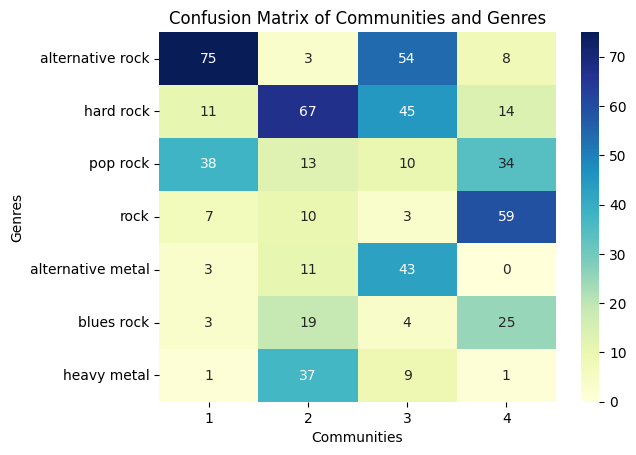

In [331]:
n_communities = len(list_communities_louvain)
n_genres = 7

def confusion_matrix_community_genres(G_backbone,top_genres,nb_communities, nb_genres):
    # Get the top genres
    top_genres_final = top_genres[:nb_genres]
    # Initialise confusion matrix
    confusion_matrix = pd.DataFrame(0, index = range(1,nb_communities+1), columns=[g for g in top_genres_final])
    
    for node in G_backbone.nodes(data=True):
        # Get all genres and community of the node   
        node_genres = node[1].get('all_genres')
        node_community = node[1].get('community')
        for node_genre in node_genres:
        # If the genre is in the top genres and community is assigned we add it to the confusion matrix
            if node_genre in top_genres_final and node_community is not None:
                confusion_matrix.loc[node_community+1,node_genre] += 1
    return confusion_matrix

top_genres_list = [genre[0] for genre in top_genres]  
confusion_matrix =confusion_matrix_community_genres(G_undirected,top_genres_list,n_communities,n_genres)

sns.heatmap(np.transpose(confusion_matrix), annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Genres")
plt.xlabel("Communities")
plt.title("Confusion Matrix of Communities and Genres")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


One community (community 4) is mostly composed of **Rock artists** and softer music like pop rock and blues rock. Another one (community 2) groups most of the heavy metal artists along with a wide part of hard rock bands, both representing **aggresive and loud music**. Community 3 seems to gather **alternative artists** (alternative rock/ alternative metal) and hard rock musicians while community 1 is primarly defined by the alternative rock artists and some pop rock bands.

Using only the fist genre for each artist would have reduced the noise from less prominent genres of artists but it may cause some relationships to be overlooked.

### **Question 2.3 :** Plot the communities and comment on your results

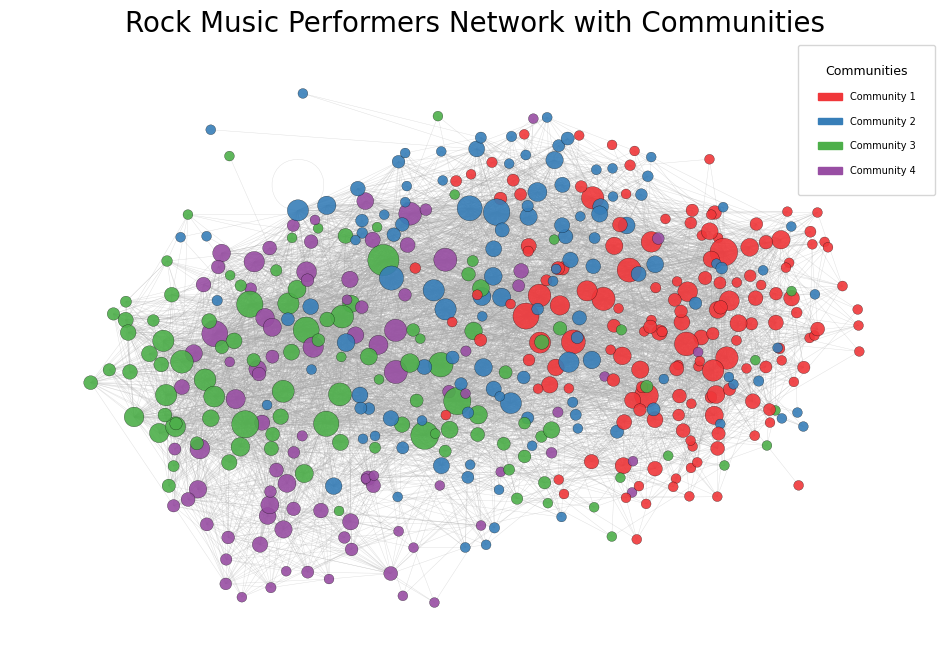

In [332]:
pos = nx.drawing.forceatlas2_layout(G_undirected)

def draw_graph_with_communities(G_undirected, pos, list_communities_louvain, title="Rock Music Performers Network with Communities"):

    # Sort communities by size and keep all communities because they are a few
    partition_sorted = sorted(list_communities_louvain, key=len, reverse=True)
    top_communities = partition_sorted

    # Manage node sizes based on degree
    deg_dict = dict(G_undirected.degree())
    node_sizes = [max(50, d * 4) for d in deg_dict.values()] 

    # Create a mapping from node to community index
    node_to_comm = {}
    for idx, comm in enumerate(top_communities):
        for node in comm:
            node_to_comm[node] = idx

    # Prepare colormap
    n_colors = max(1, len(top_communities))
    custom_colors = [
        "#f0373a",  
        "#377eb8",  
        "#4daf4a", 
        "#984ea3",  
        "#fba34c",  
        "#fbfb50",  
    ]

    # Buils a node color list based on community membership
    node_colors = []
    for node in G_undirected.nodes():
        comm = node_to_comm.get(node)
        if comm is not None and comm < len(custom_colors):
            node_colors.append(custom_colors[comm])
        else:
            node_colors.append("#d3d3d3")
            

    # Create legend entries for each community color
    legend_patches = [
        mpatches.Patch(color=custom_colors[i], label=f"Community {i + 1}")
        for i in range(len(top_communities))
    ]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G_undirected, pos, node_color=node_colors, node_size=node_sizes, linewidths=0.2, edgecolors='black', alpha=0.9)
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.4, width=0.3, edge_color="#a9a9a9")
    plt.legend(
        handles=legend_patches, 
        title="Communities", 
        fontsize=7,  # Larger font for legend items
        title_fontsize=9,  # Larger font for legend title
        loc='upper right', 
        markerscale=2,  # Increase marker scale for better visibility
        borderpad=2,  # Increase padding inside the legend box
        labelspacing=1.5,  # Increase space between legend items
        handlelength=2.5  # Increase length of color patches
    )
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

draw_graph_with_communities(G_undirected, pos, list_communities_louvain)


It is possible to distinguish the groups formed by each community on the graph, indicating that the partition is relevant. However, we also notice that the communities are not completely distinct and are intertwined, suggesting that the partition is not perfect.

### To achieve better visualization and assess whether the core nodes are well partitioned, we will visualize the backbone graph.

In [333]:

#Model 2
def backboning_graph(G, alpha_thresh):
    # Make sure the graph is undirected
    G_undirected = G.copy() 
    
    edge_betweenness = nx.edge_betweenness_centrality(G_undirected, normalized=False)
    normalized_weights = 1 + (np.array(list(edge_betweenness.values())) - min(edge_betweenness.values())) * (99 / (max(edge_betweenness.values()) - min(edge_betweenness.values())))
    # get edges
    edges = list(G_undirected.edges())

    # build the weights dictionary
    normalized_weights_dict = {
    edge: float(normalized_weights[i]) for i, edge in enumerate(edges)
        }

    # assign weights to edges
    nx.set_edge_attributes(G_undirected, normalized_weights_dict, "weight")

    # Suppose that your graph is G with weights 'weight'
    edges_data = [(u, v, w['weight']) for u, v, w in G_undirected.edges(data=True)]
    df_edges = pd.DataFrame(edges_data, columns=['src', 'trg', 'nij'])

    # Apply the disparity filter
    df_backbone = backboning.disparity_filter(df_edges, undirected=True)
    df_backbone_filtered = df_backbone[df_backbone["score"] < alpha_thresh]


    # To reconstruct a graph from the backbone
    G_backbone = nx.Graph()
    
    for _, row in df_backbone_filtered.iterrows():
        G_backbone.add_edge(row['src'], row['trg'], weight=row['nij'], score=row['score'])
    

    return G_backbone

# Apply backboning with a chosen alpha threshold
alpha_threshold = 0.50
G_backbone = backboning_graph(G_undirected, alpha_threshold)
print("Original number of edges:", G_undirected.number_of_edges())
print("Number of edges in backbone:", G_backbone.number_of_edges())
print("Number of nodes in backbone:", G_backbone.number_of_nodes())

Original number of edges: 5958
Number of edges in backbone: 1755
Number of nodes in backbone: 453


Calculating DF score...


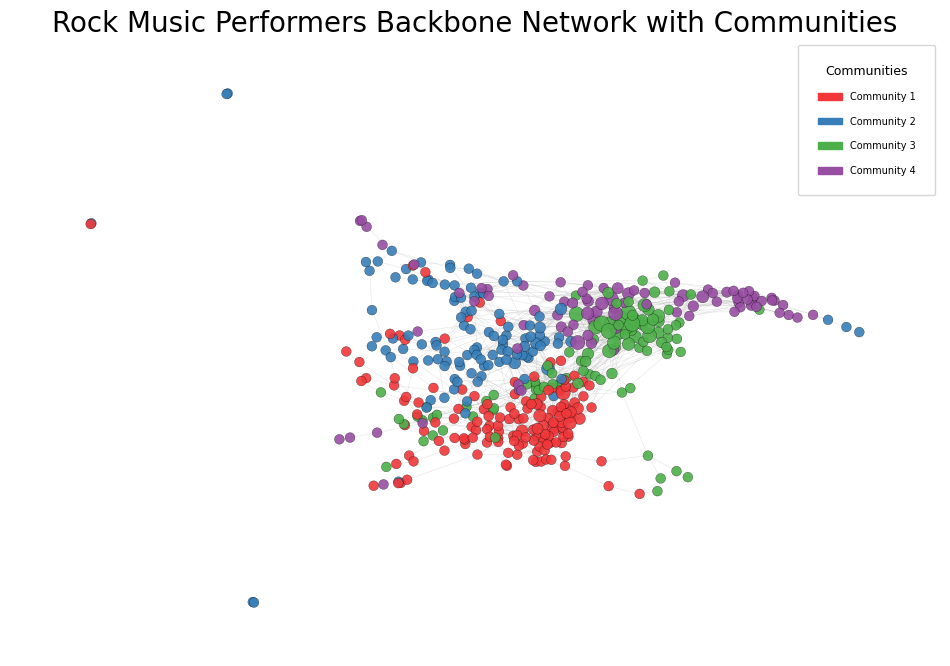

In [280]:
pos_backbone = nx.drawing.forceatlas2_layout(G_backbone, seed=42)
draw_graph_with_communities(G_backbone, pos_backbone, list_communities_louvain,title="Rock Music Performers Backbone Network with Communities")

By using the backbone graph we notice that despite some errors the communities are much more distinct. For instance, communities 1 and 4 appear to be clearly separate on the remaining nodes.

# Part 3: TF-IDF to understand genres and communities 


>* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
>* Calculate and visualize TF-IDF for the genres and communities.
>* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


### **Question 3.1 :** Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

TF-IDF is a statistical method used to reveal important words in a text within a corpus.
- It is composed of a Term Frequency (TF) : 
$$
    TF(t, d) \;=\; \frac{\text{count}(t, d)}{\sum_{t'} \text{count}(t', d)}
  $$
with : *t* = the word, *d* = the document 
- And an Inverse Document Frequency (IDF) :
$$
    IDF(t) \;=\; \log\!\left(\frac{N}{n_t}\right)
  $$
with : N = number of documents in the corpus collection, ${n_t}$ = number of documents with the word *t*

By combining these two formulas we get TF-IDF : 
$$
    TF\text{-}IDF(t, d) \;=\; TF(t, d) \times IDF(t)
$$
*Interpretation :* A higher TF-IDF value indicates that a word carries greater importance within the document relative to the entire corpus.

### **Question 3.2 :** Calculate and visualize TF-IDF for the genres and communities.

We create two dictionaries within the same function, so we need to read bands files only one time. The first dictionary contains the concatenation of all texts for the communities, and the second contains the concatenation of all texts for the genres. We consider that an artist associated with multiple genres will have their Wikipedia text included under each of the genres they belong to. So that we will miss less information. 

In [335]:
def collect_genre_and_community_datasets(G_undirected, top_genres_15,n_communities, files_bands):
    # Initialize dictionaries to hold concatenated texts
    dict_concatenate_text_genres = {genre: [] for genre in top_genres_15}
    dict_concatenate_text_communities = {f"Community_{i}": [] for i in range(1, n_communities + 1)}

    for fname in os.listdir(JSON_DIR):
        path = os.path.join(JSON_DIR, fname)
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        # get artist name from json file
        artist = data.get('page','')
        # get wikitext from json file
        wikitext = data.get('wikitext','')

        # Check if artist is in the graph
        if artist in G_undirected.nodes():
            # Get all genres of the artist
            all_genres = G_undirected.nodes[artist].get('all_genres', [])
            # Add wikitext to each genre the artist belongs to
            for genre in all_genres:
                if genre in top_genres_15:
                    # Update the wikitext for the genre
                    dict_concatenate_text_genres[genre].append(wikitext)
            # Update the wikitext for the community
            dict_concatenate_text_communities[f"Community_{G_undirected.nodes[artist]['community'] + 1}"].append(wikitext)

    return dict_concatenate_text_genres, dict_concatenate_text_communities

top_genres_15 = [genre[0] for genre in top_genres[:15]]
dict_genres_texts, dict_communities_texts = collect_genre_and_community_datasets(G_undirected, top_genres_15, n_communities, files_bands)

### Calculation for the genres

In [337]:

wiki_syntax_stopwords = ['archive', 'cite','category','cite','web','access','url','sfn','bar','nbsp']

# Helper function to replace wiki syntax
def repl_link(m):
        inner = m.group(1)
        if '|' in inner:
            return inner.split('|')[-1]  # text after |
        return inner


def export_genre_word_counts(dict_genres_texts , wiki_syntax_stopwords=wiki_syntax_stopwords):
    """
    Retourne un dictionnaire {genre: "texte complet"} 
    où chaque texte contient tous les wikitexts des artistes de ce genre,
    en minuscule et sans ponctuation.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))


    genres_data = {}
    for genre, texts in dict_genres_texts.items():
        all_text = " ".join(texts)
        
        # We want to clean the text as much as possible to get significant words and not wiki syntax. 
        # The effect of this work will be reduced by the use of IDF in TF-IDF.

        # Put everything in lowercase
        all_text = all_text.lower()
        # Remove HTML comments
        all_text =re.sub(r'<!--.*?-->', '', all_text, flags=re.DOTALL)
        # Delete links
        all_text = re.sub(r"http\S+|www\S+", " ", all_text)  
        # Delete URL status
        all_text = re.sub(r"url-status\s*=\s*(dead|live)", "", all_text, flags=re.IGNORECASE)
        # Delete wiki fields like "genre ="
        all_text = re.sub(r"\b([a-zA-Z0-9_]+)\s*=","", all_text, flags=re.IGNORECASE) 
        # Remove HTML tags
        all_text = re.sub(r"<.*?>", "", all_text) 
         
        all_text = re.sub(r'\[\[([^\]]+)\]\]', repl_link, all_text)
        # Remove templates
        all_text = re.sub(r'\{\{.*?\}\}', '', all_text, flags=re.DOTALL)
        # Remove digits and punctuation
        all_text = re.sub(r"\d+", " ", all_text)
        # Keep letters
        all_text = re.sub(r"[^\w\s]", " ", all_text)          
        # Replace multiple spaces with a single space
        all_text = re.sub(r"\s+", " ", all_text).strip()
        
        # Tokenize text
        tokens = nltk.word_tokenize(all_text)
        #  Lemmatize and remove stop words and wiki syntax stopwords
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in wiki_syntax_stopwords]
    
        # Count frequency of words
        word_counts = Counter(lemmatized_tokens)
        
        # Filter words with count < 5 and words with length < 3 because they are not significant
        to_remove = [word for word, count in word_counts.items() if count < 5]
        to_remove_small_words = [word for word in word_counts if len(word) < 3]
        for word in to_remove:
            del word_counts[word]
            
        for word in to_remove_small_words:
            del word_counts[word]
        
        # Term Frequency calculation
        total_words = sum(word_counts.values())
        tf = {word: count / total_words for word, count in word_counts.items()}
        
    
        genre_dict = {word: {"count": count, "tf": tf[word]} for word, count in word_counts.items()}
        sorted_words = dict(sorted(genre_dict.items(), key=lambda x: x[1]["count"], reverse=True))
        genres_data[genre] = sorted_words
        
        print(f"Filtered word counts for {genre}: {len(word_counts)} unique words after filtering")
        print(f"Total words for {genre}: {total_words}")
        
    return genres_data

genres_data = export_genre_word_counts(dict_genres_texts)

Filtered word counts for alternative rock: 7650 unique words after filtering
Total words for alternative rock: 394554
Filtered word counts for hard rock: 7513 unique words after filtering
Total words for hard rock: 383255
Filtered word counts for pop rock: 5975 unique words after filtering
Total words for pop rock: 264241
Filtered word counts for rock: 7114 unique words after filtering
Total words for rock: 324141
Filtered word counts for alternative metal: 4247 unique words after filtering
Total words for alternative metal: 157140
Filtered word counts for blues rock: 3879 unique words after filtering
Total words for blues rock: 126534
Filtered word counts for heavy metal: 4818 unique words after filtering
Total words for heavy metal: 184862
Filtered word counts for pop: 5552 unique words after filtering
Total words for pop: 210453
Filtered word counts for post-grunge: 2588 unique words after filtering
Total words for post-grunge: 80324
Filtered word counts for soft rock: 3195 unique w

In [338]:
def calculate_idf(genres_data, total_documents):
    
    # Count number of documents containing each word
    document_frequency = defaultdict(int)
    for genre, entry in genres_data.items():
        for word, data in entry.items():
            document_frequency[word] += 1

    # Calculate IDF for each word in each genre
    idf_data = {}
    for genre, entry in genres_data.items():
        idf_dict = {}
        for word in entry.keys():
            df = document_frequency[word]
            # +1 to avoid division by zero (even if not necessary here)
            idf = np.log(total_documents / (df))  
            idf_dict[word] = idf
        idf_data[genre] = idf_dict

    return idf_data
total_documents = len(genres_data)  # Total number of genres considered
idf_data = calculate_idf(genres_data, total_documents)


In [339]:
def compute_tfidf(genres_data, idf_data):
    tfidf_by_genre = {}
    for genre, entry in genres_data.items():
        tfidf_dict = {}
        for word, data in entry.items():
            tf = data['tf']
            idf = idf_data[genre].get(word, 0)
            tfidf = tf * idf
            tfidf_dict[word] = tfidf
        tfidf_by_genre[genre] = tfidf_dict
    return tfidf_by_genre

tfidf_data = compute_tfidf(genres_data, idf_data)

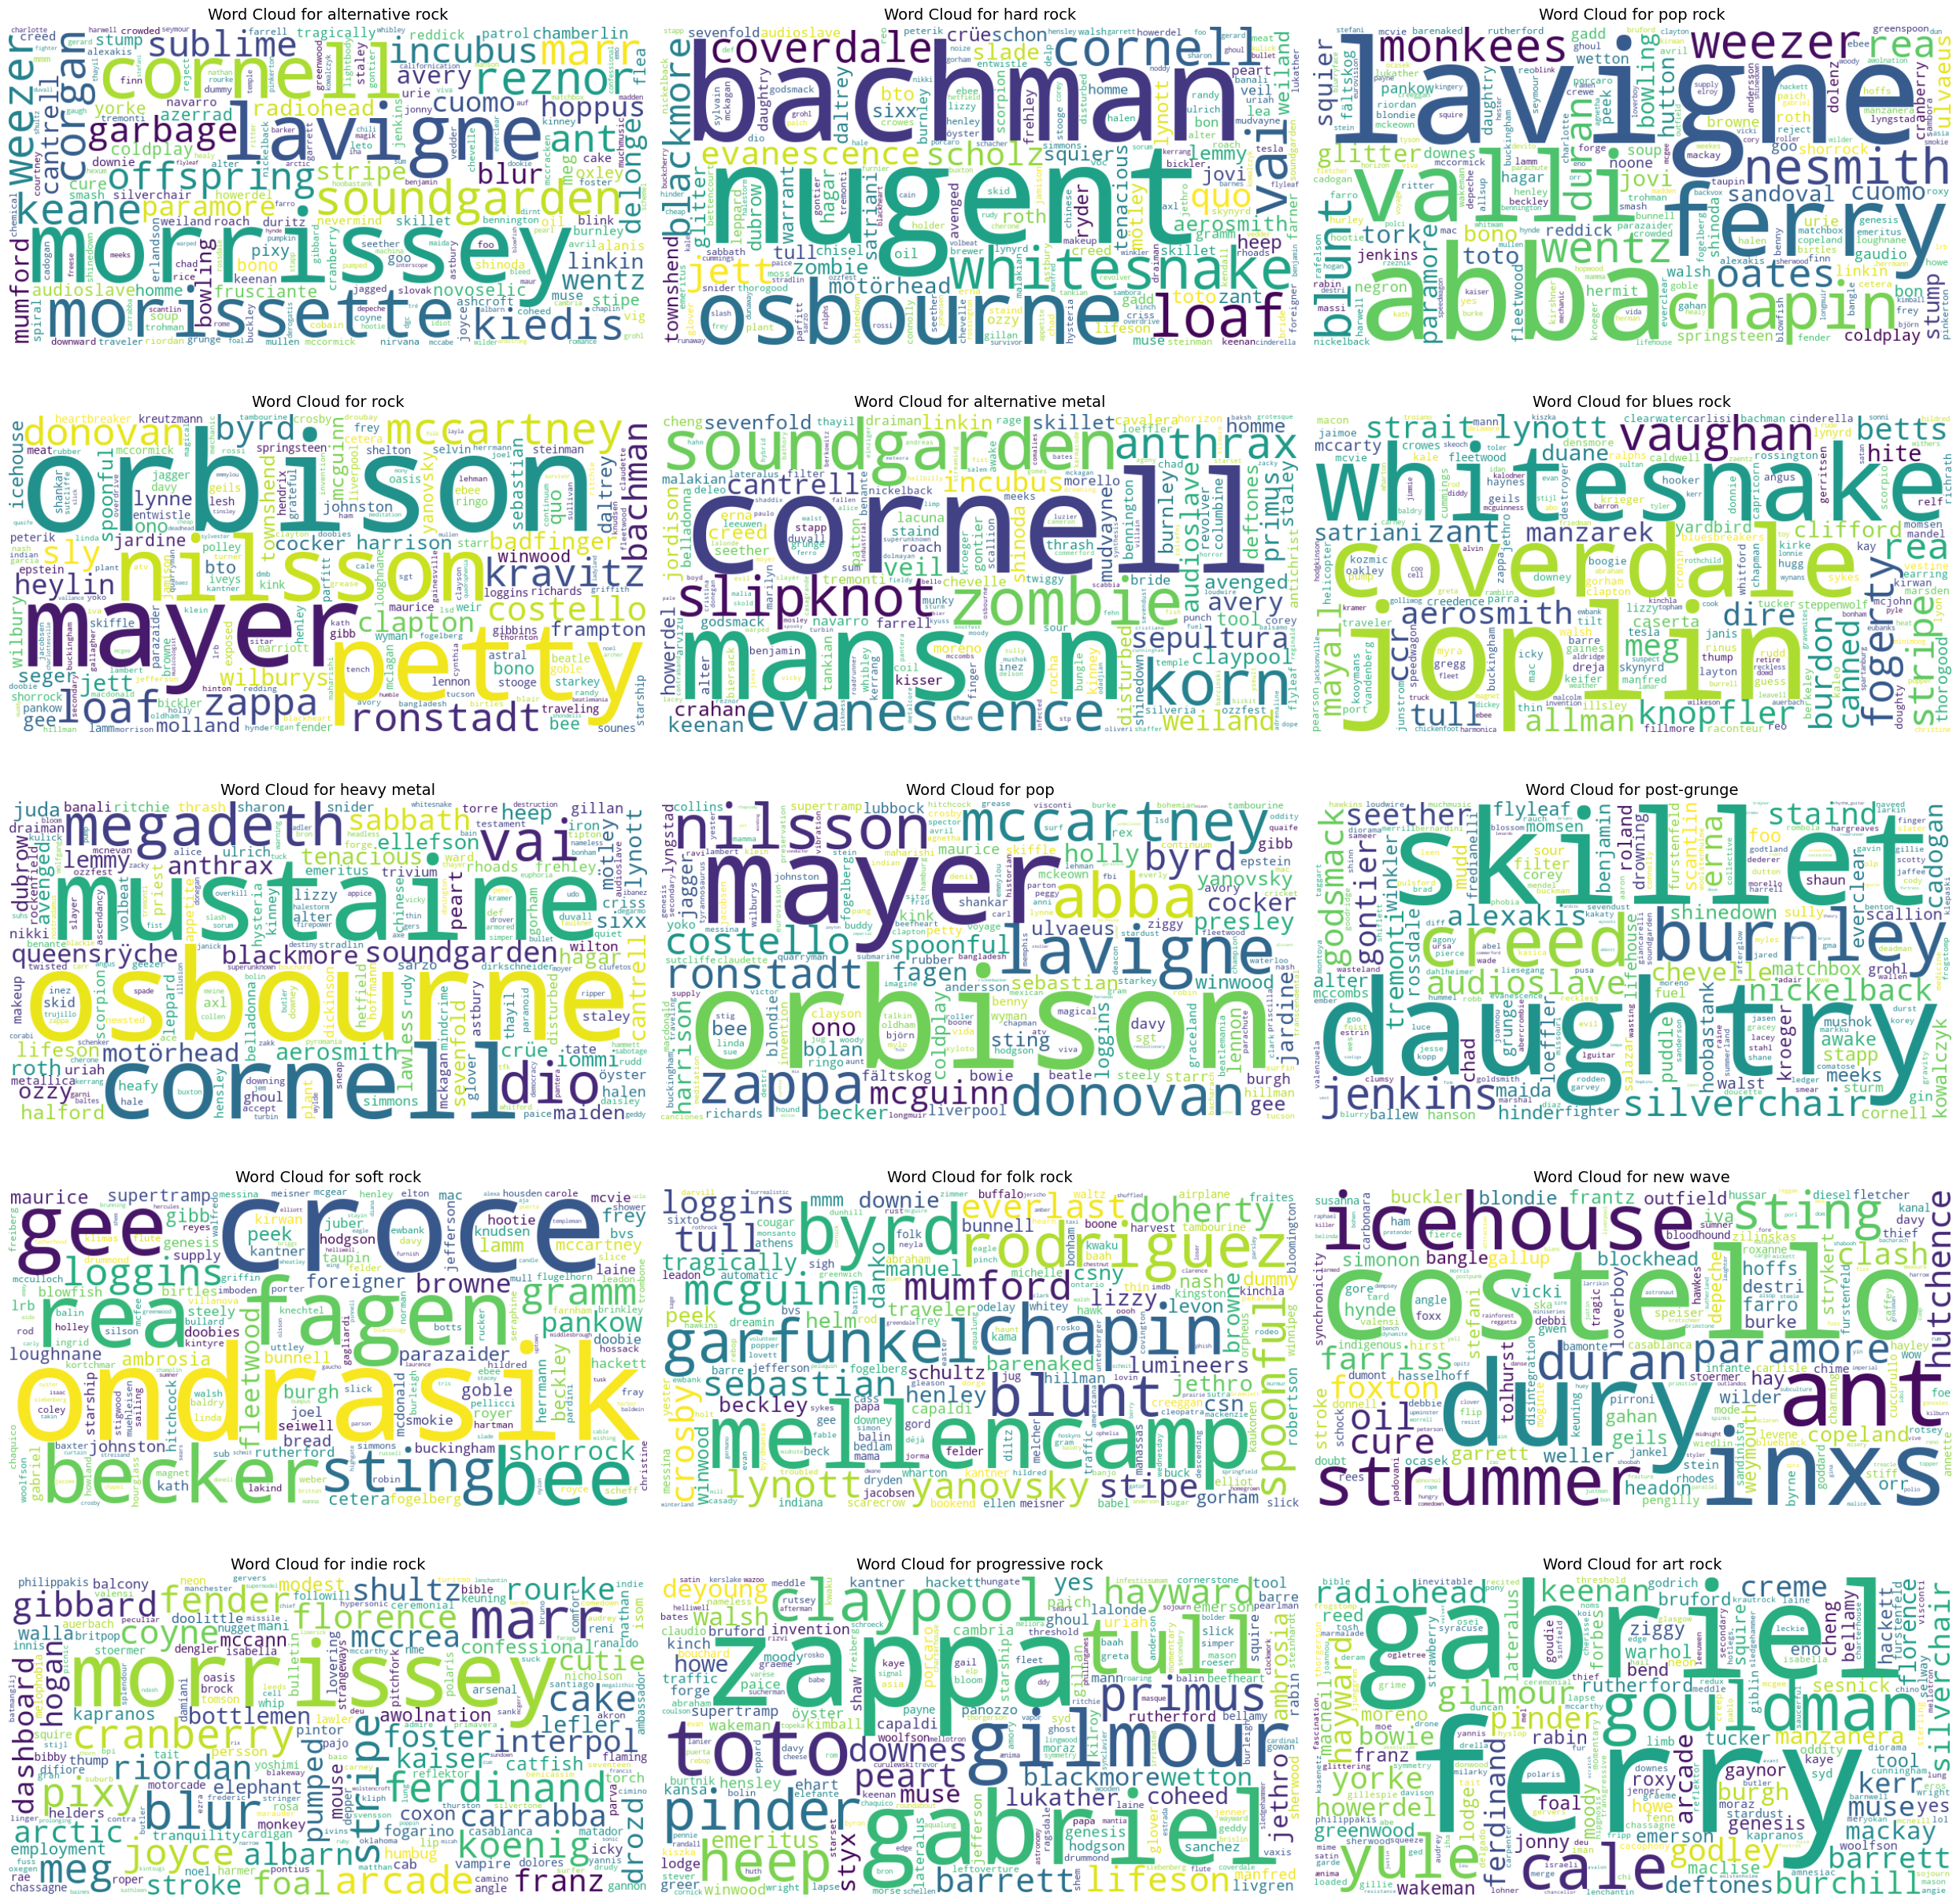

In [340]:
def plot_wordcloud_for_tfidf(top_genres, tfidf_data, number_rows=5, number_cols=3):

    fig, axes = plt.subplots(number_rows, number_cols, figsize=(25, number_rows * 5))
    axes = axes.flatten()
    
    for i, genre in enumerate(top_genres):
        # Generate word cloud
        wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis', mask=None, collocations=False)
        wc.generate_from_frequencies(tfidf_data[genre])

        # Plot word cloud
        ax = axes[i]
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Word Cloud for {genre}", fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_wordcloud_for_tfidf(top_genres_15, tfidf_data)

### Calculation for the communities

Filtered word counts for Community_1: 7562 unique words after filtering
Total words for Community_1: 367860
Filtered word counts for Community_2: 6829 unique words after filtering
Total words for Community_2: 322001
Filtered word counts for Community_3: 5413 unique words after filtering
Total words for Community_3: 228521
Filtered word counts for Community_4: 9481 unique words after filtering
Total words for Community_4: 544514


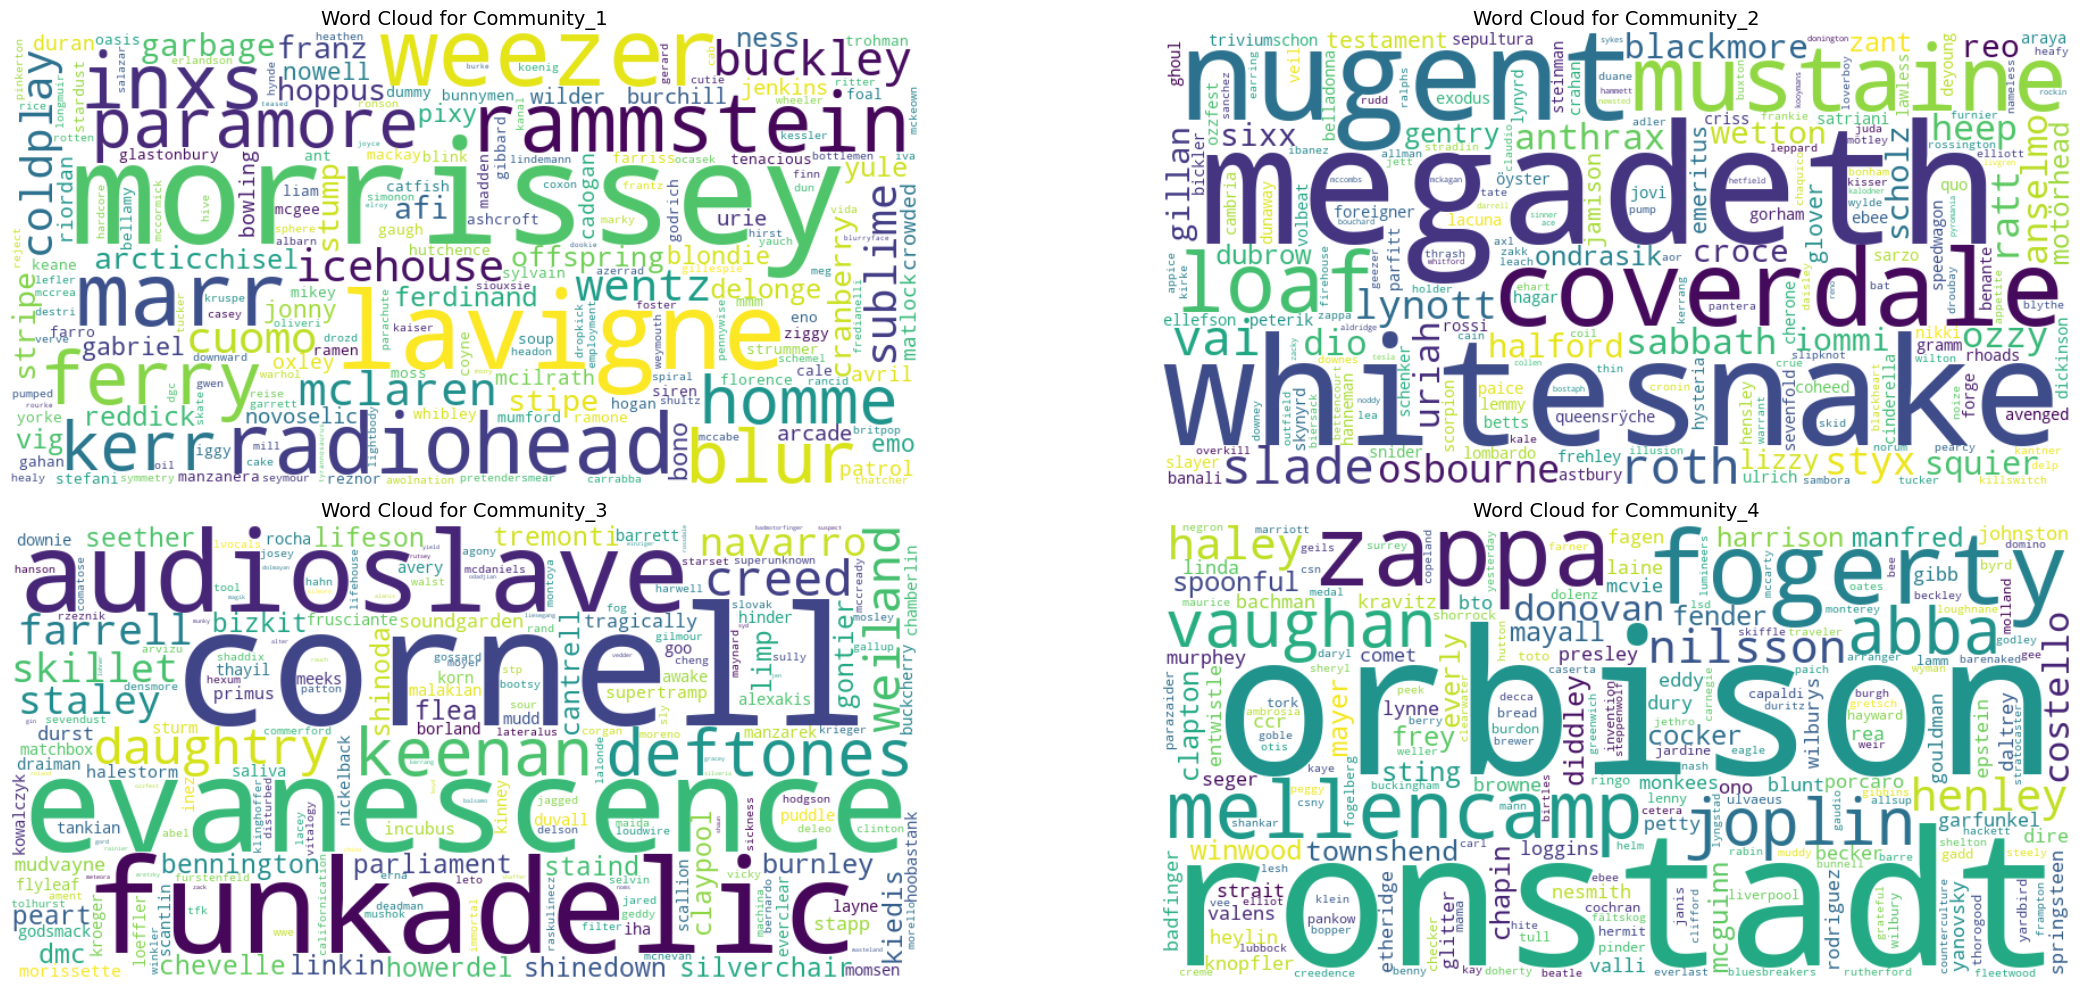

In [341]:
# We can use the same function as those used for genres.

communities_data = export_genre_word_counts(dict_communities_texts)
total_documents_communities = len(communities_data)  # Total number of genres considered
idf_data_communities = calculate_idf(communities_data, total_documents_communities)
tfidf_data_communities = compute_tfidf(communities_data, idf_data_communities)

# Create list of community names to match the logic of the function plot_wordcloud_for_tfidf
top_communities = []
for i in range(n_communities):
    top_communities.append(f"Community_{i+1}")
    
plot_wordcloud_for_tfidf(top_communities, tfidf_data_communities, number_cols=2,number_rows=2)


We notice that in the community and genre word clouds the predominant words are the names of the artists. This is expected, since an artist is frequently mentioned within the Wikipedia pages of other artists in the same genre, and rarely in pages of distant genres. As a result, the term frequency (TF) is relatively high, the inverse document frequency (IDF) is also high, and therefore the TF-IDF score for these artist names is high.

### **Question 3.3 :** Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

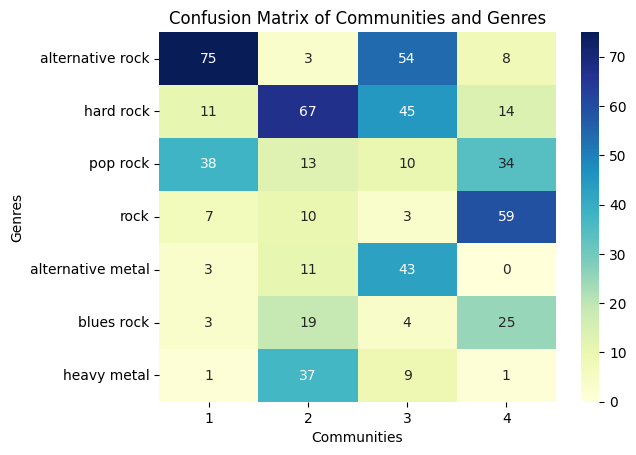

In [342]:
# As a reminder the matrix D is the following one.
sns.heatmap(np.transpose(confusion_matrix), annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Genres")
plt.xlabel("Communities")
plt.title("Confusion Matrix of Communities and Genres")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

According to D, Community 1 is expected to be primarily composed of alternative rock and pop rock artists. We find some artists in common between Community 1 and these genres in the word clouds, such as Lavigne, Morrissey, Weezer, and Ferry. However, other prominent words in Community 1, such as Rammstein, Radiohead, Marr, and INXS, do not appear in alternative rock or pop rock. This indicates that Community 1 is not exclusively associated with these genres.

Nevertheless, Community 2 does not exhibit this disparity. Most of the artists in its word cloud also appear in the hard rock or heavy metal word clouds, which are the two main genres contained in Community 2. However, some artists, such as Roth or Slade, appear much larger in the Community 2 word cloud than in their respective genre clouds.

We also notice that no prominent words are repeated between the community word clouds, whereas it is possible to find the same word or artist in two different genre clouds, such as Lavigne, Orbison, Weezer, or Evanescence. This suggests that the community partition better reflects the structure and collections within our dataset than the genre partition.

# Part 4: Sentiment of the artists and communities


>* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
>* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?